In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import gc
from glob import glob
import random
import datetime
import time


pd.options.display.float_format = '{:.2f}'.format

In [2]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, ward, fcluster
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.linear_model import LinearRegression
from scipy import stats

In [3]:
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
import sys
sys.path.append('D:\\JupyterNotebook\\_______IMPORTS\\')
import imports1
from imports1 import *

import import_clickhouse
from import_clickhouse import *

## Предобработка сэмплов

In [12]:
qq_digit = """select * from(select * from (select zcustid, WAVE
    , sum(CHECK_SUM) as rto 
    , count(TRANSACTION_DT) as cnt_trn
    , avg(CHECK_SUM) as avg_checks
    , max(CHECK_SUM) as max_check
from (
select LOYALTY_CARD_ID as zcustid
    , TRANSACTION_DT
    , sum(CHECK_SUM) as CHECK_SUM
from DWHD.TRANSACTIONS t 
where 1=1
    and TRANSACTION_DTTM between toDate('2020-07-01') and  toDate('2020-12-01')
    and LOYALTY_CARD_TYPE_ID in (26, 31, 41)
    and LOCATION_ID in (select distinct LOCATION_ID from DWHD.TRANSACTIONS t
                        where TRANSACTION_DT = (select toDate(max(TRANSACTION_DTTM))+1 as dates_ from snb_karusel.stat_all_cup sac
                                                where WAVE = 47
                                                and TRN_TYPE = 'R')
    --and LOYALTY_CARD_ID in (select LOYALTY_CARD_ID from DWHD.TRANSACTIONS where TRANSACTION_DTTM >= toDate('2020-12-01'))
    and LOYALTY_CARD_ID not in (select DISTINCT LOYALTY_CARD_ID from DWHD.ACCOUNTS a
                                where LOYALTY_CARD_STATUS not in ('A', 'P')))
    group by zcustid, TRANSACTION_DT) t1
left join (select distinct WAVE, USAGE_DATE as TRANSACTION_DT from snb_karusel.digital_stat_replaces dsr final
			where isNull(TRANSACTION_DT)=0
            and WAVE between 35 and 47) t2
USING(TRANSACTION_DT)	
group by zcustid, WAVE) t1
left join (select distinct WAVE, LOYALTY_CARD_ID as zcustid, COUPON from snb_karusel.store_all_coupon
            where COUPON_ID not like '%L%'
            and ACCOUNT_ID!=0) t2
USING(WAVE, zcustid)) t1

left join (
select zcustid, WAVE, sum(zsale_vat - zcst) as fm from (
select * from (         select toDateTime(day_partitioned) as day_partitioned, zcustid, zsale_vat, zcst
from snb_karusel.checks_headers_karusel t2
where zsale_vat > 0
and day_partitioned between toDate('2020-07-01') and  toDate('2020-12-01') 
and zcustid like '7789%') t1
left join (select distinct WAVE, USAGE_DATE as day_partitioned from snb_karusel.digital_stat_replaces dsr final
			where isNull(day_partitioned)=0
            and WAVE between 35 and 47) t2
USING(day_partitioned))
group by zcustid, WAVE                                   
) t2 
USING(WAVE, zcustid)
    """

qq_slip = """select * from(select * from (select zcustid, WAVE
    , sum(CHECK_SUM) as rto 
    , sum(cnt_trn) as cnt_trn
    , avg(CHECK_SUM) as avg_checks
    , max(CHECK_SUM) as max_check
    --, min(min_dt), max(max_dt)
    , max(sap) as max_sap
    , anyHeavy(most_common) as most_common
from (
select LOYALTY_CARD_ID as zcustid
    , TRANSACTION_DT
    , count(TRANSACTION_DTTM) as cnt_trn
    , min(TRANSACTION_DTTM) as min_dt, max(TRANSACTION_DTTM) as max_dt
    , sum(CHECK_SUM) as CHECK_SUM
    , length(groupUniqArray(LOCATION_ID)) as sap
    , anyHeavy(LOCATION_ID) as most_common
from DWHD.TRANSACTIONS t 
where 1=1
    and TRANSACTION_DTTM between toDate('2020-07-01') and  toDate('2020-12-21')
    and LOYALTY_CARD_TYPE_ID in (26, 31, 41)
    and LOCATION_ID in (select distinct LOCATION_ID from DWHD.TRANSACTIONS t
                        where TRANSACTION_DT = (select toDate(max(TRANSACTION_DTTM))+1 as dates_ from snb_karusel.stat_all_cup sac
                                                where WAVE = 47
                                                and TRN_TYPE = 'R'))
    and LOCATION_ID in (select distinct loc_sap_code as LOCATION_ID from snb_karusel.zavody_city zc   
                            where loc_city_agg not like 'Москв%' and loc_city_agg not like 'Санкт%' and  loc_city_agg not like 'Гатч%')                       
    --and LOYALTY_CARD_ID not in (select DISTINCT LOYALTY_CARD_ID from DWHD.ACCOUNTS a
    --                            where LOYALTY_CARD_STATUS not in ('A', 'P'))
    group by zcustid, TRANSACTION_DT) t1
left join (select distinct WAVE-1 as WAVE, USAGE_DATE as TRANSACTION_DT from snb_karusel.digital_stat_replaces dsr final
			where isNull(TRANSACTION_DT)=0
            and WAVE between 40 and 47) t2
USING(TRANSACTION_DT)	
group by zcustid, WAVE) t1
left join (select distinct WAVE, LOYALTY_CARD_ID as zcustid, COUPON from snb_karusel.store_all_coupon
            where COUPON_ID not like '%L%'
            --and COUPON like '1%'
            ) t2
USING(WAVE, zcustid)) t1

left join (
select zcustid, WAVE, sum(zsale_vat - zcst) as fm from (
select * from (         select toDateTime(day_partitioned) as day_partitioned, zcustid, zsale_vat, zcst
from snb_karusel.checks_headers_karusel t2
where zsale_vat > 0
and day_partitioned between toDate('2020-07-01') and  toDate('2020-12-21') 
and zcustid like '7789%') t1
left join (select distinct WAVE-1 as WAVE, USAGE_DATE as day_partitioned from snb_karusel.digital_stat_replaces dsr final
			where isNull(day_partitioned)=0
            and WAVE between 40 and 47) t2
USING(day_partitioned))
group by zcustid, WAVE                                   
) t2 
USING(WAVE, zcustid)"""
df_sample = result_to_df(qq_slip)

df_sample.shape

(3062436, 10)

In [13]:
df_sample = df_sample.loc[df_sample.WAVE!=0]
df_sample.shape

(1946832, 10)

In [15]:
frod = df_sample.loc[df_sample.max_sap>2].zcustid
df_sample = df_sample.loc[~df_sample.zcustid.isin(frod)]

In [16]:
cg_crd_reg = result_to_df("""select  LOYALTY_CARD_ID as zcustid from snb_karusel.store_all_coupon
            where COUPON_ID not like '%L%'
            and ACCOUNT_ID != 0
            and COUPON like 'reg'
            and WAVE = 47
            """)

# cg_crd_digit = result_to_df("""select LOYALTY_CARD_ID as zcustid from snb_karusel.store_all_coupon
#             where COUPON_ID not like '%L%'
#             and ACCOUNT_ID != 0
#             and (COUPON like '%cas%' or COUPON like '%d1%')
#             and WAVE = 47
#             """)
# cg_crd_digit.shape

In [17]:
gc.collect()

144

In [18]:
df_sample.loc[df_sample.zcustid.isin(cg_crd_reg.zcustid)].zcustid.nunique()
# df_sample.loc[df_sample.zcustid.isin(cg_crd_digit.zcustid)].zcustid.nunique()

48533

In [20]:
# df_sample = df_sample.loc[
# #                         (df_sample.COUPON.isin(perc_coup)) |
#                            (df_sample.COUPON.str.contains('d10')) | 
#                            (df_sample.COUPON.str.contains('d_cash')) | 
#                          (df_sample.COUPON.str.len()==0)
# ]

# df_sample = df_sample.loc[
# #                         (df_sample.COUPON.isin(perc_coup)) |
#                            ((df_sample.COUPON.str.contains('1000_')) | 
#                          (df_sample.COUPON.str.len()==0)) & ~(df_sample.COUPON.str.contains('cash'))
#                                                               & ~(df_sample.COUPON.str.contains('d1'))
#                                                               & ~(df_sample.COUPON.str.contains('perc'))
# ]

df_sample = df_sample.loc[
#                         (df_sample.COUPON.isin(perc_coup)) |
                           (df_sample.COUPON.str.contains('reg')) | 
                         (df_sample.COUPON.str.len()==0) 
]
df_sample.shape

(1306443, 10)

In [21]:
df_sample.COUPON.value_counts()

       1295431
reg      11012
Name: COUPON, dtype: int64

In [1620]:
df_sample.WAVE.value_counts().sort_index()

40    162364
41    157426
42    160814
43    159770
44    162557
45    164114
46    172732
47    166666
Name: WAVE, dtype: int64

In [22]:
WAVE_PERIOD = 46

In [1394]:
a = df_sample.loc[df_sample.WAVE<WAVE_PERIOD].groupby('zcustid').agg({'WAVE': 'first', 
                                                                      'max_check': max, 
                                                                      'rto': sum, 
                                                                      'cnt_trn': min,
#                                                                       'avg_checks': 'mean',
                                                                      'fm':sum,
#                                                                       'avg_fm':'mean'                                                                    
                                                                     })
a.head()

,WAVE,max_check,rto,cnt_trn,avg_checks,fm
zcustid,,,,,,
7789001100000207,45,207.00,207.00,1,207.00,10.70
7789001100000371,39,1209.87,3025.87,1,756.47,838.04
7789001100000686,39,799.00,799.00,1,799.00,166.00
7789001100000884,36,639.00,639.00,1,639.00,174.70
7789001100001148,39,805.06,1607.06,1,401.76,338.69


In [1395]:
a.WAVE.value_counts().sort_index()

35    170618
36    140056
37    158187
38    134246
39    132823
40    136996
41    125062
42    129823
43    128051
44    132291
45    143392
Name: WAVE, dtype: int64

In [1253]:
low, high = np.percentile(a.max_check, [5,95])
rto_low, rto_high = np.percentile(a.rto, [5,95])
checks_low, checks_high = np.percentile(a.avg_checks, [5,95])
low, high, rto_low, rto_high, checks_low, checks_high

(159.96,
 5681.682000000003,
 176.95199999999997,
 12462.976000000006,
 139.96,
 4208.0)

In [678]:
# df_sample = df_sample.loc[df_sample.zcustid.isin(
#                             a.loc[
#                                    (a.WAVE < 38)
#                                  ].index)]

In [1622]:
df_sample.loc[df_sample.COUPON.str.len()>0].zcustid.nunique()

11012

In [1254]:
# df_sample = df_sample.loc[df_sample.zcustid.isin(
#                             a.loc[
#                                    (a.max_check > low)
#                                   & (a.max_check < high)
#                                   & (a.rto > rto_low)
#                                   & (a.rto < rto_high)
#                                    & (a.avg_checks > checks_low)
#                                   & (a.avg_checks < checks_high)
#                                  ].index)]

In [22]:
# df_comm_exlude = result_to_df("""select distinct LOYALTY_CARD_ID from snb_karusel.store_all_coupon sac
#                             where `YEAR` = 2020
#                             and WAVE < (
#                             select max(WAVE) from snb_karusel.digital_stat_replaces dsr final
#                             where ACTIVATE_DATE < toDate('2020-11-02'))""")

# df_comm_test = result_to_df("""select distinct LOYALTY_CARD_ID from snb_karusel.store_all_coupon sac
#                             where `YEAR` = 2020
#                             and COUPON_ID not like '%L%'
#                             and WAVE > 43
#                             and WAVE < (
#                             select max(WAVE) from snb_karusel.digital_stat_replaces dsr final
#                             where ACTIVATE_DATE <toDate('2020-11-30'))
#                             """)

In [24]:
WAVE_PERIOD

46

In [25]:
df_opt = pd.DataFrame()
for f in range(WAVE_PERIOD,WAVE_PERIOD+2):
    df_opt = pd.concat([df_opt, 
                        pd.read_excel(rf'P:\\CRM_Karusel\\SMS\\Купоны\\2020\\W{f}\\All_cards\\SLIP\\no_coupon.xlsx'
                                      , dtype='str', usecols=['LOYALTY_CARD_ID'])
                       ], axis=0).drop_duplicates()
    print(df_opt.shape)

(787699, 1)
(838707, 1)


In [26]:
opt_crd = df_sample.loc[(df_sample.WAVE>=WAVE_PERIOD)
                        & (df_sample.zcustid.isin(df_exc_by_acc.LOYALTY_CARD_ID)) 
                        & (df_sample.COUPON.str.len()==0)
                       ]
crd_comm = df_sample.loc[df_sample.zcustid.isin(df_sample.loc[(df_sample.WAVE<=WAVE_PERIOD)
                                                      & (df_sample.COUPON.str.len()!=0)].zcustid)
                       ]

opt_crd.shape, crd_comm.shape

((77785, 10), (0, 10))

In [27]:
df_sample = df_sample.loc[~df_sample.zcustid.isin(opt_crd.zcustid)]
df_sample = df_sample.loc[~df_sample.zcustid.isin(crd_comm.zcustid)]
df_sample.shape

(1113640, 10)

In [28]:
df_sample['period'] = 'A'
df_sample.loc[df_sample.WAVE==WAVE_PERIOD, 'period'] = 'AA'
df_sample.loc[df_sample.WAVE>WAVE_PERIOD, 'period'] = 'B'

In [29]:
df_sample.head()

,zcustid,WAVE,rto,cnt_trn,avg_checks,max_check,max_sap,most_common,COUPON,fm,period
4,7789771033837194,43,821.49,1,821.49,821.49,1,1169,,270.12,A
5,7789001101893493,42,606.27,1,606.27,606.27,1,1126,,193.53,A
6,7789001145160636,45,98.00,1,98.00,98.00,1,1186,,27.61,A
18,7789001190884528,40,2097.95,2,2097.95,2097.95,1,1141,,567.84,A
19,7789001142958321,40,676.61,1,676.61,676.61,1,1082,,155.88,A


In [30]:
df_sample_concat = df_sample.drop('max_sap', axis=1).copy()

In [31]:
df_sample_concat['cg'] = 0
df_sample_concat.loc[df_sample_concat.zcustid.isin(df_sample_concat.loc[df_sample_concat.COUPON.str.len()>0].zcustid), 'cg'] = 1
# df_sample_concat.loc[df_sample_concat.zcustid.isin(cg_crd_digit.zcustid), 'cg'] = 1
df_sample_concat.groupby(['cg', 'period'])['zcustid'].nunique()

cg  period
0   A         524069
    AA        128512
    B         117843
1   A           9976
    AA          4246
    B          10698
Name: zcustid, dtype: int64

In [32]:
df_sample_piv = df_sample_concat.drop('COUPON', axis=1).pivot_table(index=['zcustid', 'cg', 'period']
                                                             , columns='WAVE', aggfunc='first', fill_value=0
                                                            ).reset_index()

In [33]:
b = df_sample_concat.loc[df_sample_concat.WAVE<WAVE_PERIOD].groupby('zcustid').agg({'WAVE': 'nunique'
                                                               , 'max_check':[min, max, 'mean'], 'rto':[sum, 'mean']
                                                               , 'cnt_trn':[min, max, 'mean']
                                                               , 'avg_checks':[min, max]}).reset_index()
b.head()

zcustid    WAVE max_check                     rto         cnt_trn  \
                    nunique       min     max    mean     sum    mean     min   
0  7789001100000207       1    207.00  207.00  207.00  207.00  207.00       1   
1  7789001100000371       3    949.00 1209.87 1053.62 3160.87 1053.62       1   
2  7789001100000884       1    484.87  484.87  484.87  484.87  484.87       1   
3  7789001100001148       2    119.00  147.00  133.00  266.00  133.00       1   
4  7789001100001841       1    143.00  143.00  143.00  143.00  143.00       1   

           avg_checks          
  max mean        min     max  
0   1 1.00     207.00  207.00  
1   2 1.33     949.00 1209.87  
2   1 1.00     484.87  484.87  
3   1 1.00     119.00  147.00  
4   1 1.00     143.00  143.00

In [34]:
df_sample_piv = df_sample_piv.merge(b, how='left', on='zcustid')
df_sample_piv = df_sample_piv.dropna()

## Скейлиенг и PCA

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_sample_piv.loc[(df_sample_piv.cg==0) 
                                                        & (df_sample_piv.period=='A')].drop(['zcustid', 'cg', 'period'], axis=1))
X_test_scaled = scaler.transform(df_sample_piv.loc[(df_sample_piv.cg==1) 
                                                   & (df_sample_piv.period=='A')].drop(['zcustid', 'cg', 'period'], axis=1))

(0, 20)

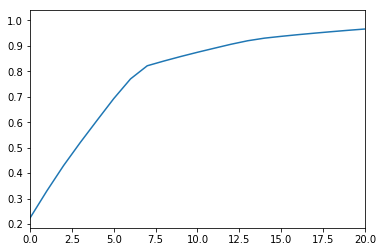

In [36]:
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,20,1)

In [37]:
pca = PCA(n_components=11)
pca_train = pca.fit_transform(X_train_scaled)
pca_test = pca.transform(X_test_scaled)

In [38]:
df_sample_piv.loc[(df_sample_piv.cg==1) & (df_sample_piv.period=='A')].zcustid.nunique()

9976

## NearestNeighbors

In [39]:
nn = NearestNeighbors(n_neighbors=1, radius=1.0, algorithm='auto'
             , leaf_size=30
             , metric='cosine'
#              , p=2
             , metric_params=None, n_jobs=-4)
nn.fit(pca_train)
distance, neigh = nn.kneighbors(pca_test, n_neighbors=1, return_distance=True)

target_crd = df_sample_piv.loc[(df_sample_piv.cg==0) & (df_sample_piv.period=='A')].reset_index(drop=True)
crd_test= list(df_sample_piv.loc[(df_sample_piv.cg==1) & (df_sample_piv.period=='A')].zcustid.values)
crd_cg =  list(target_crd.iloc[list(neigh.flatten())].zcustid.values)

In [40]:
df_ab = pd.DataFrame()
df_ab['test']  = crd_test    
df_ab['cg']  = crd_cg
df_ab['distance'] = distance
df_ab['target'] = 0
df_ab = df_ab.sort_values('distance').drop_duplicates('cg')

In [41]:
df_ab.shape

(9790, 4)

In [43]:
len(crd_test), len(crd_cg), len(neigh), X_test_scaled.shape, target_crd.shape

(9976, 9976, 9976, (9976, 59), (524069, 62))

In [42]:
df_target = df_sample_concat.loc[df_sample_concat.zcustid.isin(list(df_ab.cg.values)+list(df_ab.test.values))]
df_target['target'] = 0
df_target.loc[df_target.zcustid.isin(df_ab.test.values), 'target'] = 1
df_target.shape

(55786, 12)

In [2053]:
df_target.groupby('target')['zcustid'].nunique()

target
0    9844
1    9844
Name: zcustid, dtype: int64

In [2054]:
df_target.groupby('WAVE')['zcustid'].nunique()

WAVE
40     4724
41     4707
42     5104
43     7438
44     7969
45     8877
46     5787
47    11515
Name: zcustid, dtype: int64

In [2004]:
# low, high = np.percentile(df_target.max_check, [5,95])
# rto_low, rto_high = np.percentile(df_target.rto, [5,95])
# avg_low, avg_high = np.percentile(df_target.avg_checks, [5,95])
# trn_low, trn_high = np.percentile(df_target.cnt_trn, [5,95])

# low, high = np.percentile(df_target.max_check, [25,75])
# IQR = high-low
# low_check = low-1.5*IQR
# high_check = high-1.5*IQR

In [2065]:
df_target_period = df_target.groupby(['period', 'target', 'zcustid'])[['rto', 'cnt_trn', 'fm']
                                           ].sum().reset_index()
df_target_period.drop('zcustid', axis=1).groupby(['period', 'target']).agg({'mean'})

rto cnt_trn     fm
                 mean    mean   mean
period target                       
A      0      2427.88    2.58 498.76
       1      2420.20    2.59 501.19
AA     0      1413.04    1.44 286.00
       1      1392.27    1.50 281.77
B      0      1464.33    1.45 302.67
       1      1403.81    1.36 277.51

In [2086]:
df_target.drop('zcustid', axis=1).groupby(['period', 'WAVE', 'target']).agg({'mean', 'std'})

rto         cnt_trn      avg_checks         max_check  \
                       std    mean     std mean        std    mean       std   
period WAVE target                                                             
A      40   0      1381.21 1234.65    0.82 1.33    1155.68 1082.24   1213.69   
            1      1337.31 1227.80    0.80 1.34    1141.13 1073.54   1208.23   
       41   0      1252.47 1168.25    0.80 1.33    1057.42 1018.19   1108.81   
            1      1244.83 1172.90    0.72 1.32    1112.06 1036.58   1142.88   
       42   0      1307.42 1198.67    0.74 1.33    1122.29 1039.72   1186.41   
            1      1311.58 1200.08    0.74 1.33    1160.41 1053.64   1205.37   
       43   0      1345.10 1212.15    0.69 1.28    1191.39 1079.31   1226.67   
            1      1336.60 1203.72    0.67 1.29    1193.45 1082.87   1245.51   
       44   0      1363.17 1248.15    0.69 1.29    1210.61 1109.85   1253.03   
            1      1388.82 1241.36    0.68 1.30    1289.00 1120.09   1320.71   
       45   0      1452.99 1289.14    0.69 1.31    1247.20 1133.46   1314.32   
            1      1379.56 1273.15    0.68 1.31    1239.95 1137.10   1289.74   
AA     46   0      1608.25 1413.04    0.94 1.44    1238.53 1159.60   1355.66   
            1      1485.89 1392.27    1.10 1.50    1157.41 1112.09   1235.02   
B      47   0      1645.79 1464.33    1.15 1.45    1405.70 1233.57   1463.27   
            1      1704.50 1403.81    0.76 1.36    1472.98 1207.02   1550.58   

                               fm          cg       
                      mean    std   mean  std mean  
period WAVE target                                  
A      40   0      1135.79 346.38 253.50 0.00    0  
            1      1130.32 331.76 251.06 0.00    1  
       41   0      1074.64 295.30 236.83 0.00    0  
            1      1083.36 298.06 238.36 0.00    1  
       42   0      1095.91 326.54 246.04 0.00    0  
            1      1106.86 341.20 248.53 0.00    1  
       43   0      1122.85 344.69 250.50 0.00    0  
            1      1126.84 348.07 252.00 0.00    1  
       44   0      1160.77 342.33 256.94 0.00    0  
            1      1166.27 361.79 259.84 0.00    1  
       45   0      1192.11 375.00 264.95 0.00    0  
            1      1190.09 359.83 262.98 0.00    1  
AA     46   0      1251.43 407.04 286.00 0.00    0  
            1      1206.56 393.13 281.77 0.00    1  
B      47   0      1315.37 439.27 302.67 0.00    0  
            1      1281.09 442.86 277.51 0.00    1

In [2000]:
# drop_outl = df_target.loc[
#       (df_target.max_check < low) 
#     | (df_target.max_check > high)
#     | (df_target.rto < rto_low)
#     | (df_target.rto > rto_high)
#     | (df_target.avg_checks < avg_low)
#     | (df_target.avg_checks > avg_high)
#     | (df_target.cnt_trn < trn_low)
#     | (df_target.cnt_trn > trn_high)
#       ].zcustid
# drop_outl.shape

(2829,)

In [2001]:
# df_target = df_target.loc[~df_target.zcustid.isin(drop_outl)]

## В чем сложность ?

* Слишком большая дисперсия - сложно отследить различия в группах и какой-либо эффект
* Данные неоднородны: не каждую неделю ходят в магазин, в магазинах разный траффик и рто, залетный или жилмассив
* Необходимо уменьшать дисперсию: стратификация, линеаризация, бутстрап, CUPED 

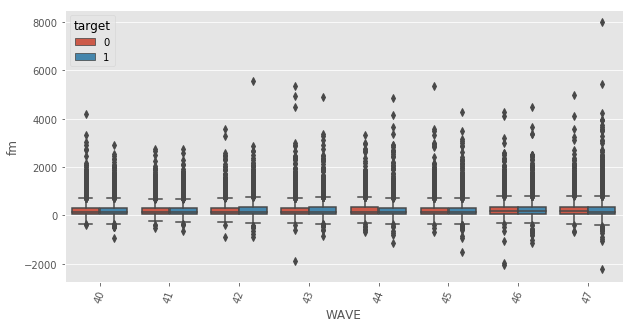

In [2064]:
plt.figure(figsize=(10, 5))
g = sns.boxplot(data=tt
             , x='WAVE'
             , y='fm'
             , hue='target'
#              , estimator=np.mean
            )
g.set_xticklabels(sorted(tt.WAVE.unique()));
plt.xticks(rotation=70);

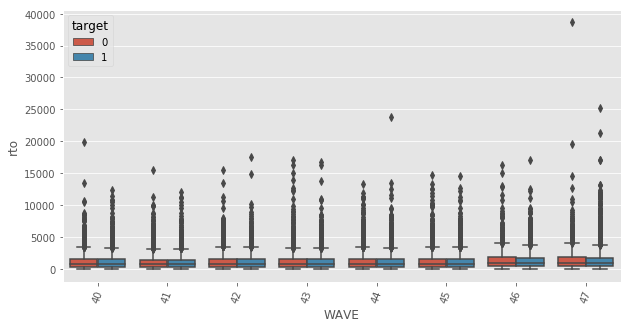

In [2063]:
plt.figure(figsize=(10, 5))
g = sns.boxplot(data=tt
             , x='WAVE'
             , y='rto'
             , hue='target'
#              , estimator=np.mean
            )
g.set_xticklabels(sorted(tt.WAVE.unique()));
plt.xticks(rotation=70);

* <strong>p-уровень значимости, p-критерий</strong> — вероятность получить для данной вероятностной модели распределения значений случайной величины <strong>такое же или более экстремальное значение статистик</strong>и (среднего арифметического, медианы и др.), по сравнению с ранее наблюдаемым, <strong>при условии, что нулевая гипотеза верна</strong>

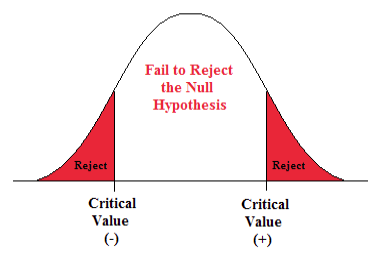

## MDE

* Доверительный интервал для среднего

$$\bar{X} - Z_{\alpha/2}{\sigma \over \sqrt{n}} < \mu < \bar{X} + Z_{\alpha/2}{\sigma \over \sqrt{n}}$$

* Отсюда мы можем узнать как ширина дов интервала зависит от размера выборки  

$$Z_{\alpha/2}{\sigma \over \sqrt{n}} = Margin Of Error = E$$

$$ n = ({Z_{\alpha/2}\sigma \over E})^{2} $$

* Таким образом при фиксированном уровне значимости и эффекте, который мы хотим наблюдать, можно рассчитать минимальный размер выборки.
* Чем меньше мы хотим детектировать эффект, тем больше нам нужна выбока
* Т.к. увеличивать бесконечно выборку мы не можем, а уровень значимости мы хотим оставить приемлемый, то остается уменьшать дисперсию метрики:
    - при уменьшении дисперсии в 2 раза - допустимый размер выборки уменьшается в 2 раза
    - при уменьшении E в 10 раз - допустимый размер выборки увеличивается в 100 раз

## bootstrap

* Генерим N бутрстреп выборок с возвращением, по ЦПТ выборочные статистики будут иметь нормальное распределение

In [140]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm, shapiro
from scipy.stats import rankdata, poisson
from statsmodels.graphics.gofplots import qqplot 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [129]:
def ttst(a,b):
    return ttest_ind(a, b).pvalue

def mwit(a,b):
    return mannwhitneyu(a, b, alternative='two-sided').pvalue

def get_bootstrap_(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    print(pd_boot_data.shape)     
    print(len(boot_data))
    return {#"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    func = ttst
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    means_1 = []
    means_2 = []
    for _ in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(func(samples_1, samples_2)) 
        means_1.append(np.mean(samples_1))
        means_2.append(np.mean(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)
        
    return means_1, means_2, pd_boot_data

def plot_stat(df, label):
    sorted_data = np.sort(df[0])
    position = rankdata(sorted_data, method='ordinal')
    cdf = position / sorted_data.shape[0]
    sorted_data = np.hstack((sorted_data, 1))
    cdf = np.vstack((cdf.reshape(-1,1), 1))
    fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax2.axvline(0.05, color='k', alpha=0.5)
    ax2.plot(sorted_data, cdf, color='red', linestyle='solid');
    plt.title(label)
    sns.distplot(df[0], kde=False, ax=ax1);

In [1702]:
np.random.seed(5)

### introduction

* Для примера сделаем 5000 бутстрэп-выборок РТО одной из волны, проверим равенство средних т-тестом и посмотрим на распределение p-value.
* В качестве сэмплов подадим контрольные группы - мы хотим при равенстве средних убедиться, что наш метод нахождения похожих групп рабочий
* Доля ошибок 2 рода не дожна превышать 5%

* На левом графике видно, что распределение p-value - равномерное
* На правом графике мы видим, что FPR (доля экспериментов в которых мы видим неравенство средних) при отсечении в 5% как раз составляет 5%

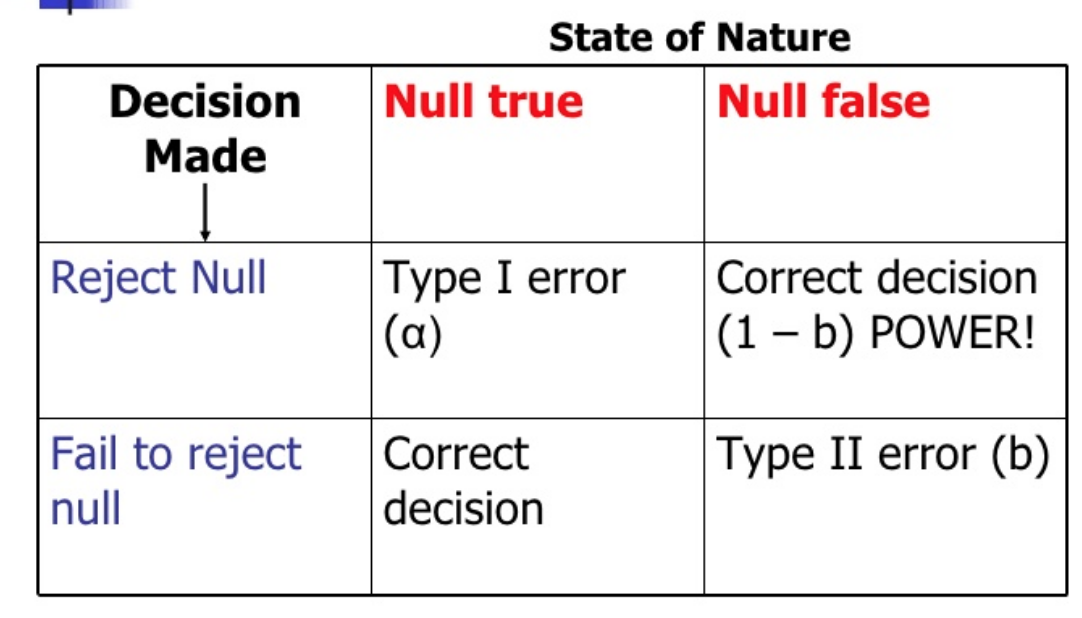

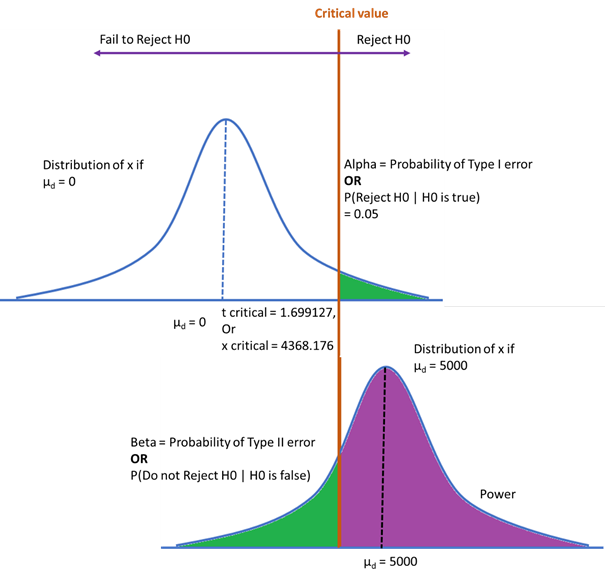

0.0496

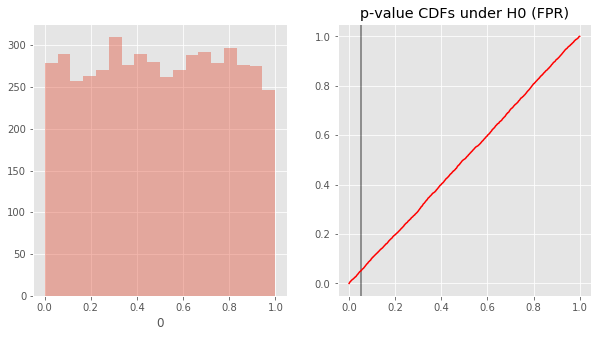

In [2066]:
cg_group = df_target.loc[(df_target.WAVE==44) & (df_target.cg==0)].rto
_,_,boot = get_bootstrap(cg_group, cg_group,
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=ttst) 
plot_stat(boot, 'p-value CDFs under H0 (FPR)');
np.mean(boot[0] < 0.05)

* Теперь представим, что есть аплифт и посмотрим на результаты
* Аплифт 3%

0.2354

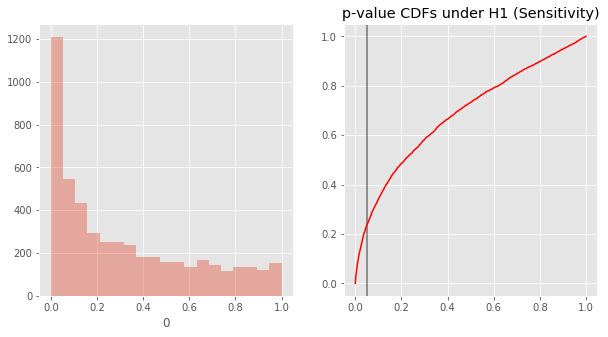

In [2067]:
cg_group = df_target.loc[(df_target.WAVE==44) & (df_target.cg==0)].rto
_,_,boot = get_bootstrap(cg_group, cg_group*(1+0.03),
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=ttst) 
plot_stat(boot, 'p-value CDFs under H1 (Sensitivity)');
np.mean(boot[0] < 0.05)

* Видим, что распределение p-value уже неравномерное
* При отсечении альфы 5% получим 23% случаев, когда средние не равны - т.е. мощность нашего теста
* Увеличим аплифт до 7%

0.776

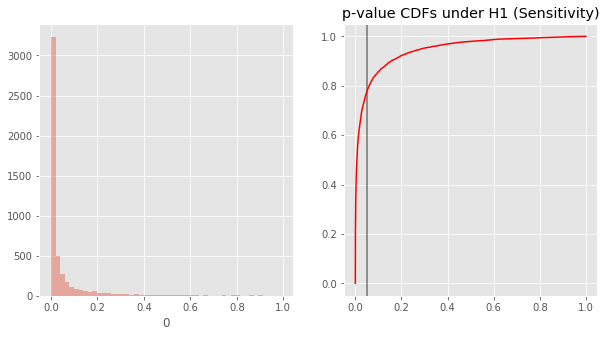

In [136]:
cg_group = df_target.loc[(df_target.WAVE==44) & (df_target.cg==0)].rto
s1,s2,boot = get_bootstrap(cg_group, cg_group*(1+0.07),
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=ttst) 
plot_stat(boot, 'p-value CDFs under H1 (Sensitivity)');
np.mean(boot[0] < 0.05)

* Наша мощность теста увеличилась до приемлемых  почти 80%
* Т.е. с желаемой мощностью теста в 80% мы можем отловить эффект начиная с 7%

* Посмотрим как мы подобрали группы

### Shapiro-Wilka на нормальность бутстреп-статистики

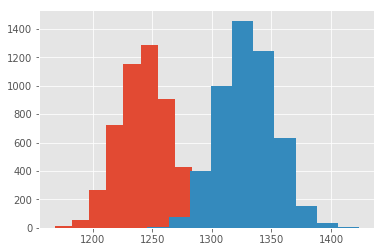

In [138]:
plt.hist(s1);
plt.hist(s2);

In [139]:
_, p= shapiro(s1)
p # нормальное

0.47838884592056274

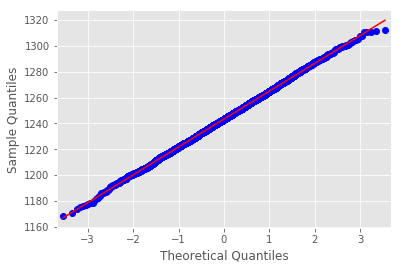

In [146]:
qqplot(np.array(s1), line='s');

### ttest

In [2071]:
# По волнам
waves = []
rto = []
trn = []
fm = []
for w in sorted(df_target.WAVE.unique()):
    
    cg_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==0)].rto
    test_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==1)].rto

    _, _, booted_data_rto = get_bootstrap(cg_group, test_group,
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=ttst) # 
    cg_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==0)].cnt_trn
    test_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==1)].cnt_trn

    _, _, booted_data_trn = get_bootstrap(cg_group, test_group,
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=ttst) # 
    cg_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==0)].fm
    test_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==1)].fm

    _, _, booted_data_fm = get_bootstrap(cg_group, test_group,
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=ttst) # 
    
    waves.append(w)
    rto.append(np.mean(booted_data_rto[0] < 0.05))
    trn.append(np.mean(booted_data_trn[0] < 0.05))
    fm.append(np.mean(booted_data_fm[0] < 0.05))
    
df_type_error = pd.DataFrame(data={'w':waves,  'rto':rto, 'trn':trn, 'fm':fm})

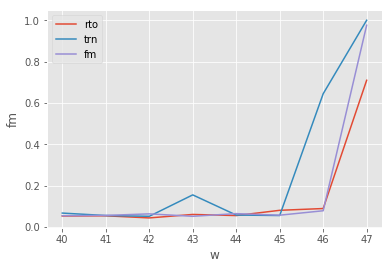

In [2072]:
sns.lineplot(x=df_type_error.w, y=df_type_error.rto, label='rto');
sns.lineplot(x=df_type_error.w, y=df_type_error.trn, label='trn');
sns.lineplot(x=df_type_error.w, y=df_type_error.fm, label='fm');

* В некоторых волнах (43) наблюдаются ошибки 2 рода более 5%
* В предпилотной волне 46 (АА-тест) - также большие ошибки 2 рода
* Возможные причины - маленькие размеры групп, короткий период волны 7 дней - высокая дисперсия метрик, т.к. человек не ходит каждую неделю в гипермаркет

* посмотрим на пилотную волну: средние всех метрик в семплах не равны

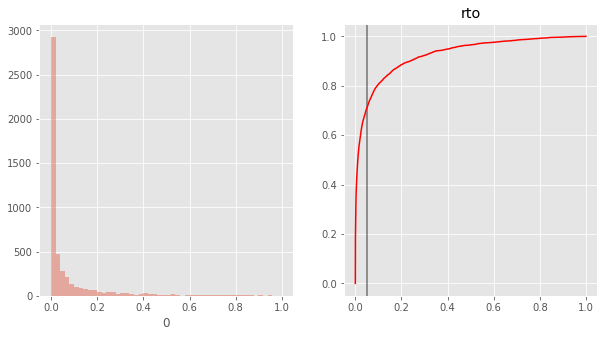

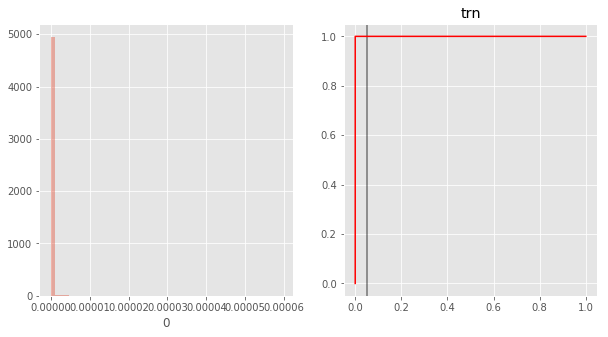

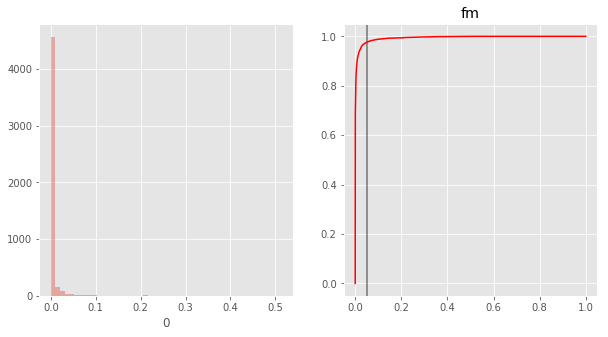

In [2073]:
plot_stat(booted_data_rto, 'rto');
plot_stat(booted_data_trn, 'trn');
plot_stat(booted_data_fm, 'fm');

* попробуем схлопнуть до периодов

In [2074]:
# По периодам
period = []
rto = []
trn = []
fm = []
for w in sorted(df_target_period.period.unique()):
    cg_group = df_target_period.loc[(df_target_period.period==w) & (df_target_period.target==0)].rto
    test_group = df_target_period.loc[(df_target_period.period==w) & (df_target_period.target==1)].rto

    _, _, booted_data_rto = get_bootstrap(cg_group, test_group,
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=ttst) # 
    cg_group = df_target_period.loc[(df_target_period.period==w) & (df_target_period.target==0)].cnt_trn
    test_group = df_target_period.loc[(df_target_period.period==w) & (df_target_period.target==1)].cnt_trn

    _, _, booted_data_trn = get_bootstrap(cg_group, test_group,
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=ttst) # 
    cg_group = df_target_period.loc[(df_target_period.period==w) & (df_target_period.target==0)].fm
    test_group = df_target_period.loc[(df_target_period.period==w) & (df_target_period.target==1)].fm

    _, _, booted_data_fm = get_bootstrap(cg_group, test_group,
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=ttst) # 
    period.append(w)
    rto.append(np.mean(booted_data_rto[0] < 0.05))
    trn.append(np.mean(booted_data_trn[0] < 0.05))
    fm.append(np.mean(booted_data_fm[0] < 0.05))
    
df_type_error = pd.DataFrame(data={'period':period, 'rto':rto, 'trn':trn, 'fm':fm})

In [2079]:
df_type_error

,w,rto,trn,fm
0,40,0.06,0.10,0.06
1,41,0.06,0.04,0.05
2,42,0.05,0.05,0.07
3,43,0.05,0.15,0.05
4,44,0.06,0.06,0.06
5,45,0.05,0.07,0.06
6,46,0.05,0.96,0.05
7,47,0.34,1.00,0.90


* Результаты похожие 

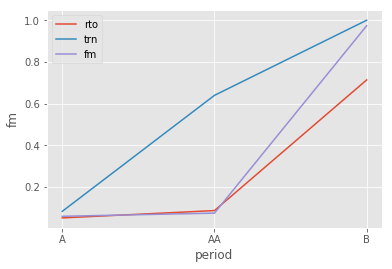

In [2075]:
sns.lineplot(x=df_type_error.period, y=df_type_error.rto, label='rto');
sns.lineplot(x=df_type_error.period, y=df_type_error.trn, label='trn');
sns.lineplot(x=df_type_error.period, y=df_type_error.fm, label='fm');

### mann whitney

Т.к. данные у нас неравномерны и ттест к ним чувствителен, воспользуемся ранговые критерием Манна-Уитни

In [2076]:
waves = []
rto = []
trn = []
fm = []
for w in sorted(df_target.WAVE.unique()):
    cg_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==0)].rto
    test_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==1)].rto

    _, _, booted_data_rto = get_bootstrap(cg_group, test_group,
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=mwit) # 
    cg_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==0)].cnt_trn
    test_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==1)].cnt_trn

    _, _, booted_data_trn = get_bootstrap(cg_group, test_group,
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=mwit) # 
    cg_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==0)].fm
    test_group = df_target.loc[(df_target.WAVE==w) & (df_target.cg==1)].fm

    _, _, booted_data_fm = get_bootstrap(cg_group, test_group,
                                boot_it = 5000, # количество бутстрэп-подвыборок
                               func=mwit) # 
    
    waves.append(w)
    rto.append(np.mean(booted_data_rto[0] < 0.05))
    trn.append(np.mean(booted_data_trn[0] < 0.05))
    fm.append(np.mean(booted_data_fm[0] < 0.05))
    
df_type_error = pd.DataFrame(data={'w':waves,  'rto':rto, 'trn':trn, 'fm':fm})
df_type_error

,w,rto,trn,fm
0,40,0.06,0.10,0.06
1,41,0.06,0.04,0.05
2,42,0.05,0.05,0.07
3,43,0.05,0.15,0.05
4,44,0.06,0.06,0.06
5,45,0.05,0.07,0.06
6,46,0.05,0.96,0.05
7,47,0.34,1.00,0.90


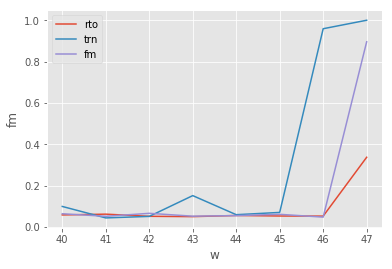

In [2077]:
sns.lineplot(x=df_type_error.w, y=df_type_error.rto, label='rto');
sns.lineplot(x=df_type_error.w, y=df_type_error.trn, label='trn');
sns.lineplot(x=df_type_error.w, y=df_type_error.fm, label='fm');

* Результат похожий

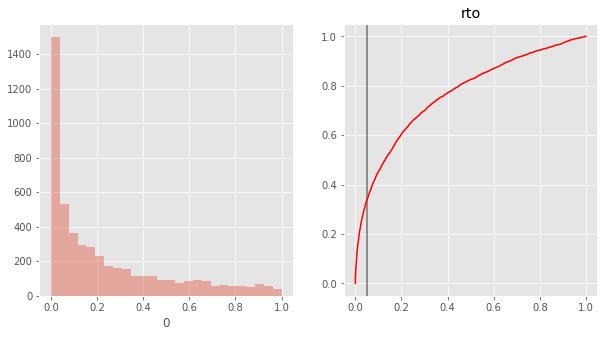

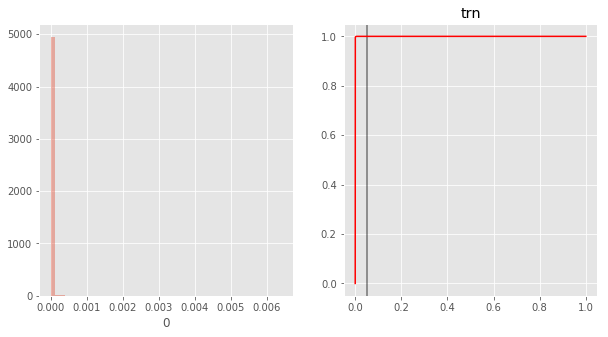

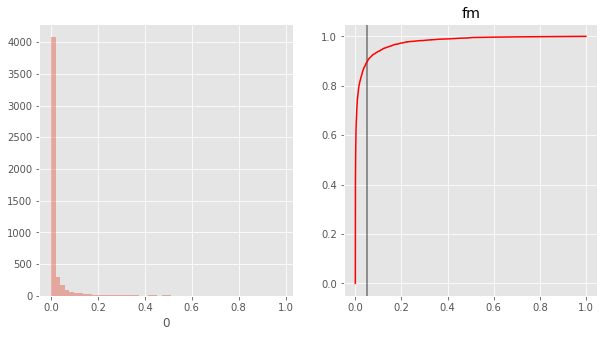

In [2078]:
plot_stat(booted_data_rto, 'rto');
plot_stat(booted_data_trn, 'trn');
plot_stat(booted_data_fm, 'fm');

Как улучшить?
* Агрегировать по месяцам
* Смотреть менее дисперсионные метрики - например доля маржи

## Методы понижения дисперсии

### Linearization

* Линеаризуем - в пилотные волны (46 волна АА и 47 АБ) вычтем средние сэмплов за предыдущий период

In [2312]:
df_mean_ = df_target.loc[df_target.period=='A'].groupby(['zcustid']).agg({'mean'}).reset_index()[['zcustid', 'rto', 'fm', 'avg_checks']]

In [2313]:
df_linear = df_target.loc[(df_target.period!='A')].copy()
df_linear = df_linear.merge(df_mean_, how='left', on='zcustid')
df_linear['lin_rto'] = df_linear['rto'] - df_linear[('rto', 'mean')]
df_linear['lin_fm'] = df_linear['fm'] - df_linear[('fm', 'mean')]
df_linear['lin_avg_checks'] = df_linear['avg_checks'] - df_linear[('avg_checks', 'mean')]

In [2314]:
df_linear.groupby(['period', 'target'])[['rto', 'lin_rto', 'fm', 'lin_fm', 'avg_checks', 'lin_avg_checks']].agg({'mean', 'std'})

rto         lin_rto            fm        lin_fm        \
                  std    mean     std   mean    std   mean    std  mean   
period target                                                             
AA     0      1608.25 1413.04 1426.42  90.44 407.04 286.00 379.02 12.36   
       1      1485.89 1392.27 1399.74 127.19 393.13 281.77 389.66 22.03   
B      0      1645.79 1464.33 1383.01 179.21 439.27 302.67 388.04 38.60   
       1      1704.50 1403.81 1639.36 146.00 442.86 277.51 443.59 16.30   

              avg_checks         lin_avg_checks         
                     std    mean            std   mean  
period target                                           
AA     0         1238.53 1159.60        1077.92  32.20  
       1         1157.41 1112.09        1072.80  24.30  
B      0         1405.70 1233.57        1154.57 103.72  
       1         1472.98 1207.02        1387.05  80.77

* Видим что у линеаризованных метрик дисперсия уменьшилась

### Stratification

* Суть метода в измерении стратифицированной дисперисии 
* В качестве страты например можно выбрать город, магазин
* Остановимся на городе

In [119]:
df_strat = df_target.loc[(df_target.WAVE==47)][['zcustid', 'WAVE', 'target', 'rto']]
df_strat.groupby('target').agg({'mean', 'std'})

WAVE          rto        
        std mean     std    mean
target                          
0      0.00   47 1483.83 1397.52
1      0.00   47 1705.17 1407.60

In [120]:
city = result_to_df("""select distinct loc_sap_code as LOCATION_ID, loc_city_agg from snb_karusel.zavody_city zc""")
city = city.set_index('LOCATION_ID')['loc_city_agg'].to_dict()
df_sample['city'] = df_sample.most_common.map(city)
df_strat = df_strat.merge(df_sample.loc[df_sample.WAVE==47][['zcustid', 'city']], how='left', on='zcustid')

In [121]:
weight_city = df_strat.city.value_counts(normalize=True).to_dict()

In [122]:
mean_strat = 0
std_strat = 0
std_strat_cov = 0
mean_target = df_strat.loc[(df_strat.target==1)].rto.mean()
for cit, weight in weight_city.items():
    mean_strat += df_strat.loc[(df_strat.target==1) & (df_strat.city==cit)].rto.mean()*weight
    std_strat += weight*df_strat.loc[(df_strat.target==1) & (df_strat.city==cit)].rto.std()**2
    std_strat_cov += weight*(df_strat.loc[(df_strat.target==1) & (df_strat.city==cit)].rto.mean()-mean_target)**2
std_strat /= df_strat.loc[(df_strat.target==1)].shape[0]
std_strat_cov /= df_strat.loc[(df_strat.target==1)].shape[0]

In [124]:
mean_strat, std_strat+std_strat_cov

(1407.279487156715, 297.5233448604456)

* Cреднее стратифицированное равно среднему, а дисперсия уменьшается как минимум на дисперсию между стратами (второй член) 

$$ var(\bar{Y}) = {1 \over n} \sum_{k=1}^{K}p_{k}\sigma_{k}^{2}+\sum_{k=1}^{K}p_{k}(\mu_{k}-\mu)^{2}$$

### CUPED

* Суть метода в поиске взаимосвязи метрики до и после пилота
* Преобразуем нашу метрику после эксперимента на основе знаний метрик до эксперимента

$$ CUPED = metric - (covariate-mean(covariate))*theta $$

* metric -метрика после эксперимента
* covariate - метрика до эксперимента

* $$ theta = {covariance(metric, covariate) \over variance(covariate)} $$

In [2343]:
cup_df = df_target.loc[(df_target.WAVE>=46)][['zcustid', 'WAVE', 'target', 'rto']]
cup_df = cup_df.pivot_table(index=['zcustid', 'target'], columns='WAVE', values='rto', aggfunc='first').reset_index()
cup_df.loc[cup_df[46].isnull(), 46] = cup_df[47]  # отсутствующие ковариаты заменим средним

In [2323]:
covar = cup_df.loc[cup_df.target==1][46]
metric = cup_df.loc[cup_df.target==1][47]
theta = np.cov(metric, covar)[0,1]/ np.var(covar)
cuped = metric.values - (covar-np.mean(covar))*theta

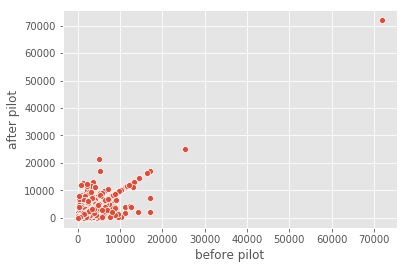

In [2345]:
sns.scatterplot(covar.values, metric.values);
plt.xlabel('before pilot');
plt.ylabel('after pilot');

In [2348]:
print('before:', np.mean(metric), np.std(metric), np.var(metric))
print('CUPED:', np.mean(cuped), np.std(cuped), np.var(cuped))

before: 1403.814748069909 1704.4127752722482 2905022.908511247
CUPED: 1403.814748069909 972.1747963491733 945123.8346565567


* также Ycuped можно вычислить с помощью МНК

In [2367]:
lr = LinearRegression()
lr.fit(covar.values.reshape(-1,1), metric.values.reshape(-1,1))
theta_lr = lr.coef_
Y_cuped_lr = metric.values - theta_lr[0][0]*(covar.values-covar.mean())

In [2369]:
VAR_CUPED = np.var(metric)+theta**2*np.var(covar)-2*theta*np.cov(metric, covar)[0,1]
VAR_CUPED

944725.5621359455

In [2370]:
print('before:', np.mean(metric), np.std(metric), np.var(metric))
print('CUPED:', np.mean(cuped), np.std(cuped), np.var(cuped))
print('CUPED_lr:', np.mean(Y_cuped_lr), np.std(Y_cuped_lr), np.var(Y_cuped_lr))

before: 1403.814748069909 1704.4127752722482 2905022.908511247
CUPED: 1403.814748069909 972.1747963491733 945123.8346565567
CUPED_lr: 1403.8147480699067 972.1747859450752 945123.8144273527


* Уменьшаем дисперсию, за счет части обусловленной ковариатой Х